In [30]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf 
import numpy as np 
import pandas as pd 
import os 

In [31]:
# random seed 고정 
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [32]:
# train file명 정리  
train_df = pd.DataFrame({ 'file' :os.listdir('./data/train')}) # dictionary 형태로~
train_df['label'] = train_df['file'].apply(lambda x : x.split('.')[0])
train_df.head()


file label
0  cat.12267.jpg   cat
1   dog.5452.jpg   dog
2   dog.8131.jpg   dog
3   cat.1403.jpg   cat
4  dog.11129.jpg   dog

In [33]:
# train test split
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_df,
    test_size = 0.2,
    stratify= train_df['label'],
    random_state = 13
)

In [34]:
# data augmentation 
train_datagen = ImageDataGenerator(
    rotation_range =15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input 
)

val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [35]:
# data frame에서 train data
FILES = './data/'
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data, # train 
    directory = FILES + 'train',
    x_col = 'file',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13,
)

Found 20000 validated image filenames belonging to 2 classes.


In [36]:
# 같은 방식으로 test data
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,   # validation 
    directory = FILES + 'train',
    x_col = 'file',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13,
    shuffle = False
)

Found 5000 validated image filenames belonging to 2 classes.


In [37]:
base_model = VGG16(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)
# include_top = false
# 분류기 부분을 제거하고, 특징 추출기(Convolutional Layers + Pooling Layers)만 포함합니다

In [38]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

원래 fc(fully connected - 전체 특징을 조합하여 전역(global) 관계를 학습) 층이 있어야하는데\
학습 가능한 가중치(parameters)를 포함하고 있는 fc를 막아서\
대신 나만의 모델(FC 또는 다른 구조)을 붙여 전이 학습을 통해 새로운 데이터셋과 작업에 맞게 모델을  커스터마이즈하기 위해서임!
![Screenshot from 2025-01-21 11-03-00.png](<attachment:Screenshot from 2025-01-21 11-03-00.png>)
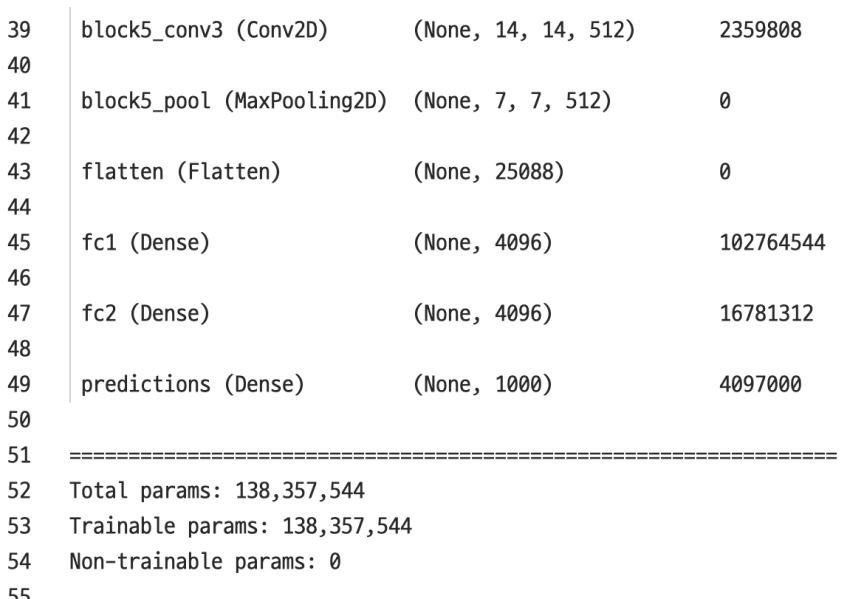

In [39]:
# 가중치 막아 ~~~~~~~!!!!!!!!!!!!!!11
for layers in base_model.layers:
    layers.trainable = False 
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
def vgg16_pretrained():
    inputs = tf.keras.Input(shape=(224,224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation ='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(2,activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model 

In [41]:
# 메모리 비우기 
tf.keras.backend.clear_session()

In [42]:
# model 재구성 
model = vgg16_pretrained()
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,772,582 (56.35 MB)

 Trainable params: 57,894 (226.15 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
# reduce learning rate 
## loss가 진전이 없으면 lr 줄여가면 진행해 봐라, 5회 이상 변화가 없을 경우 stop
## minimum learning rate의 최소(2차식 그래프에서 더이상 줄여지지 않는 가장 작은 값) 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 5,
    min_lr = 0.0001
)
# 3회 이상 변화가 없으면 일찍 멈춰라 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

In [44]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    monitor = 'val_accuracy',
    filepath = './data/vgg16_pretrained.weights.h5',
    save_best_only = True,
    save_weights_only = True    # 가중치만 기억해라 
)

In [45]:
# 학습 진행 
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 5,
    callbacks = [reduce_lr, early_stopping, check_point]
)

/home/moon/venv/tensor/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 102ms/step - accuracy: 0.9203 - loss: 0.3196 - val_accuracy: 0.9796 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.9703 - loss: 0.0754 - val_accuracy: 0.9772 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.9767 - loss: 0.0669 - val_accuracy: 0.9802 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 100ms/step - accuracy: 0.9799 - loss: 0.0569 - val_accuracy: 0.9812 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.9793 - loss: 0.0530 - val_accuracy: 0.9810 - val_loss: 0.0536 - learning_rate: 0.0010


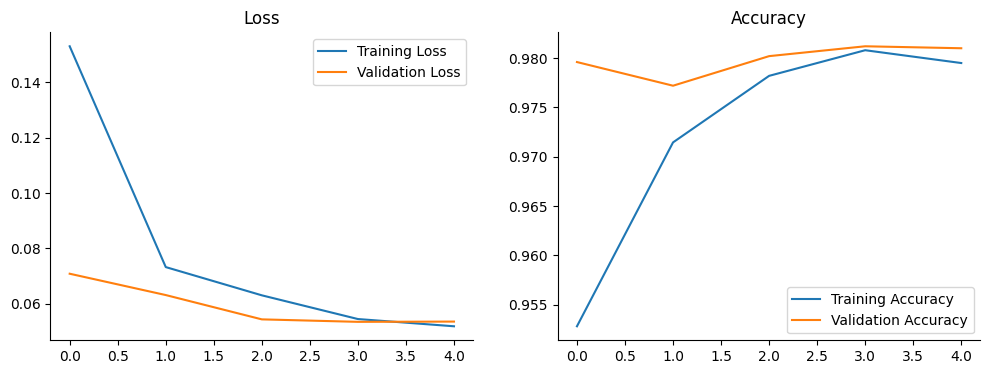

In [46]:
import matplotlib.pyplot as plt 
import seaborn as sns 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history['loss'])),
             y = history.history['loss'], ax = axes[0],
             label = 'Training Loss')
sns.lineplot(x = range(len(history.history['loss'])),
             y = history.history['val_loss'], ax = axes[0],
             label = 'Validation Loss')

sns.lineplot(x = range(len(history.history['accuracy'])),
             y = history.history['accuracy'], ax = axes[1],
             label = 'Training Accuracy')
sns.lineplot(x = range(len(history.history['accuracy'])),
             y = history.history['val_accuracy'], ax = axes[1],
             label = 'Validation Accuracy')

axes[0].set_title('Loss'); axes[1].set_title('Accuracy')

sns.despine()
plt.show()




In [47]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy: .4f}")
print(f"Validation Loss: {val_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9813 - loss: 0.0537
Validation Accuracy:  0.9810
Validation Loss: 0.0536


In [48]:
val_pred = model.predict(val_generator)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step


In [49]:
val_data.loc[:, 'val_pred'] = np.argmax(val_pred, axis=1)
labels = dict((v, k) for k, v in val_generator.class_indices.items())
val_data.loc[:, 'val_pred'] = val_data.loc[:, 'val_pred'].map(labels)

val_data.head(10)


/tmp/ipykernel_655916/3150460639.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['cat' 'dog' 'cat' ... 'cat' 'dog' 'dog']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_data.loc[:, 'val_pred'] = val_data.loc[:, 'val_pred'].map(labels)


file label val_pred
7653    cat.4556.jpg   cat      cat
18955  dog.12152.jpg   dog      dog
15578  cat.10622.jpg   cat      cat
12054   dog.3983.jpg   dog      dog
15858   dog.5659.jpg   dog      dog
6743    cat.9119.jpg   cat      cat
17274   dog.7445.jpg   dog      dog
926    dog.12275.jpg   dog      dog
17912   cat.5981.jpg   cat      dog
3667    cat.8284.jpg   cat      cat

### Confusion Matrix 


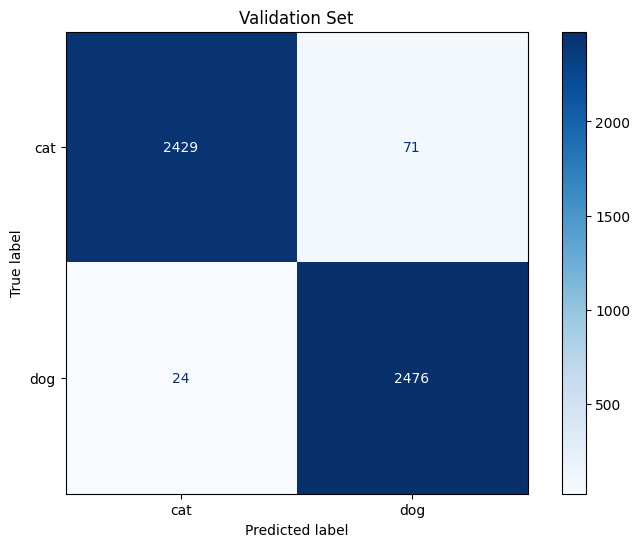

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize = (9,6))
cm = confusion_matrix(val_data['label'], val_data['val_pred'])
disp = confusion_matrix(val_data['label'], val_data['val_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['cat', 'dog'])
disp.plot(cmap=plt.cm.Blues, ax = ax)

ax.set_title('Validation Set')
plt.show()